In [688]:
import os
import pandas as pd
import numpy as np
from collections import deque
from io import StringIO
from scipy.sparse import lil_matrix, csr_matrix
from sklearn.cluster import AffinityPropagation

from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics import normalized_mutual_info_score

import matplotlib.pyplot as plt

%matplotlib inline

# Affinity Propagation на матрицах, для оценки адекватности алгоритма на графах

In [490]:
class CustomAffinityPropagation(object):
    def __init__(self, similarity_measure = None):
        if similarity_measure is None:
            self.similarity_measure = lambda x, y: -np.power(x - y, 2).sum()
        else: 
            self.similarity_measure = similarity_measure
        
        self.S = None
        self.A = None
        self.R = None
    
    def load_similarity_matrix(self, S_new):
        self.S = S_new
        if hasattr(self.S, 'todense'):
            self.A = csr_matrix((S_new.shape[0], S_new.shape[0]))
            self.R = csr_matrix((S_new.shape[0], S_new.shape[0]))
        else:
            self.A = np.zeros_like(S_new)
            self.R = np.zeros_like(S_new)
        
    def calc_similarity_matrix(self, X):
        self.S = np.zeros((X.shape[0], X.shape[0]))
        self.A = np.zeros_like(self.S)
        self.R = np.zeros_like(self.S)
        for i in range(X.shape[0]):
            for j in range(X.shape[0]):
                self.S[i, j] = self.similarity_measure(X[i,:], X[j,:])
                
        self.S[np.diag_indices_from(self.S)] = np.median(self.S)#np.random.normal(loc=-5, scale=2) / 1e-8
        
        return self.S
    
    def update_responsibility(self, damping=.9):
        # For every column k, except for the column with the maximum value the max is the same.
        # So we can subtract the maximum for every row, 
        # and only need to do something different for k == argmax

        v = self.S + self.A
        rows = np.arange(self.S.shape[0])
        # We only compare the current point to all other points, 
        # so the diagonal can be filled with -infinity
        np.fill_diagonal(v, -np.inf)

        # max values
        idx_max = np.argmax(v, axis=1)
        first_max = v[rows, idx_max]

        # Second max values. For every column where k is the max value.
        v[rows, idx_max] = -np.inf
        second_max = v[rows, np.argmax(v, axis=1)]

        # Broadcast the maximum value per row over all the columns per row.
        max_matrix = np.zeros_like(self.R) + first_max[:, None]
        max_matrix[rows, idx_max] = second_max

        new_val = self.S - max_matrix

        self.R = self.R * damping + (1 - damping) * new_val

        
    def update_availability(self, damping=0.9):
        k_k_idx = np.arange(self.S.shape[0])
        # set a(i, k)
        a = np.array(self.R)
        a[a < 0] = 0
        np.fill_diagonal(a, 0)
        a = a.sum(axis=0) # columnwise sum
        a = a + self.R[k_k_idx, k_k_idx]

        # broadcasting of columns 'r(k, k) + sum(max(0, r(i', k))) to rows.
        a = np.ones(self.A.shape) * a

        # For every column k, subtract the positive value of k. 
        # This value is included in the sum and shouldn't be
        a -= np.clip(self.R, 0, np.inf)
        a[a > 0] = 0

        # set(a(k, k))
        w = np.array(self.R)
        np.fill_diagonal(w, 0)

        w[w < 0] = 0

        a[k_k_idx, k_k_idx] = w.sum(axis=0) # column wise sum
        self.A = self.A * damping + (1 - damping) * a
    
    
    def fit_transform(self, X=None, y=None):
        if X is not None:
            self.calc_similarity_matrix(X)
            
        for i in range(1000):
            self.update_responsibility(.9)
            self.update_availability(.9)
        
        clusters = np.argmax(self.A + self.R, axis=1)
        return clusters
            

In [491]:
X, y = make_blobs(n_samples=100, centers=5, n_features=2, random_state=42)

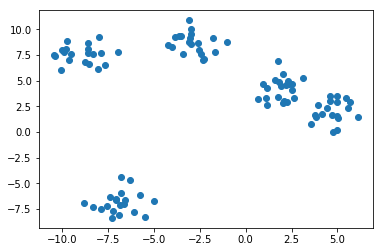

In [492]:
plt.scatter(x = X[:, 0], y = X[:, 1])

In [493]:
afine = CustomAffinityPropagation()
clusters = afine.fit_transform(X)
np.unique(clusters)#.shape

array([ 2, 11, 41, 48, 71, 78], dtype=int64)

In [494]:
unique_clust = np.unique(clusters).tolist()
mapping = dict(zip(unique_clust, range(len(unique_clust))))
mapped_clusters = np.array(list(map(lambda x: mapping[x], clusters.tolist())))

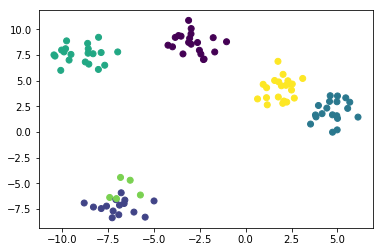

In [495]:
plt.scatter(x = X[:, 0], y = X[:, 1], c=mapped_clusters)#, cmap='tab20')

# Синтетика для теста алгоритма на графах

In [505]:
X, y = make_blobs(n_samples=100, centers=2, n_features=2, random_state=42)
synth = CustomAffinityPropagation().calc_similarity_matrix(X)
np.fill_diagonal(synth, 0)

outp_data = ''
for i in range(synth.shape[0]):
    for j in range(synth.shape[1]):
        if synth[i, j] != 0:
            outp_data += f"{i}\t{j}\t{synth[i, j]}\n"
            
with open("./Gowalla/synth.txt", "w") as f:
    f.write(outp_data)

In [548]:
rawdata = None
with open('./Gowalla/exemplars.txt', 'r') as f:
    rawdata = f.read()
    
clusters = pd.read_csv(StringIO(rawdata), sep='\t', header=None)

In [549]:
unique_clust = np.unique(clusters[1]).tolist()
mapping = dict(zip(unique_clust, range(len(unique_clust))))
mapped_clusters = np.array(list(map(lambda x: mapping[x], clusters[1].tolist())))

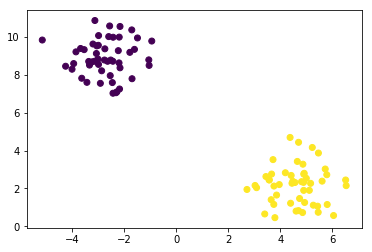

In [550]:
plt.scatter(x = X[:, 0], y = X[:, 1], c=mapped_clusters)#, cmap='tab20')

# Gowalla

# Загружаем результат кластеризации (Gowalla)

In [620]:
rawdata = None
with open('./Gowalla/exemplars.txt', 'r') as f:
    rawdata = f.read()
    
clusters = pd.read_csv(StringIO(rawdata), sep='\t', header=None)#.rename('node', 'exemplar')
clusters.columns = ['node', 'exemplar']

In [621]:
exemplars = clusters.exemplar.tolist()

In [623]:
# транзитивное замыкание

for ix_node, record in enumerate(exemplars):
    while record != exemplars[record]:
        record = exemplars[record]
    
    if record != exemplars[ix_node]:
        print(f'transitive for {ix_node}')
        exemplars[ix_node] = record

transitive for 174669


In [624]:
# транзитивное замыкание не понадобилось

In [ ]:
print('количество единичных кластеров', np.sum(clusters.exemplar.value_counts() == 1))

In [693]:
print('первые 500 кластеров по объему')
print(clusters.exemplar.value_counts())

первые 500 кластеров по объему
220       10186
440        3585
207        1021
615        1003
2196        798
3           784
1430        645
4370        577
2215        556
2089        494
1791        476
2070        353
38454       344
325         341
1408        338
4914        332
5905        330
7480        309
458         274
1614        266
5568        242
8037        241
1927        218
39549       209
1720        207
1605        196
598         165
68929       164
5849        158
1455        158
          ...  
144637        1
136441        1
138488        1
156919        1
77086         1
111313        1
83347         1
90827         1
107919        1
112013        1
76482         1
74435         1
126342        1
72388         1
120193        1
142718        1
161141        1
163188        1
70341         1
175470        1
177517        1
167274        1
191846        1
185697        1
68294         1
66247         1
94921         1
30005         1
32052         1
137475   

# Анализируем чекины

In [588]:
rawdata = None
with open('./Gowalla/Gowalla_totalCheckins.txt', 'r') as f:
    rawdata = f.read()
    
checkins = pd.read_csv(StringIO(rawdata), sep='\t', header=None)
checkins.columns = ['user_from', 'time', 'latitude', 'longitude', 'user_to']
checkins.drop(['time', 'latitude', 'longitude'], inplace=True, axis=1)

In [589]:
def get_top_checkins(x):
    top_5 = x.user_to.value_counts().iloc[:10].index.values
    return pd.Series(top_5)

top_checkins = checkins.groupby('user_from').apply(get_top_checkins).unstack()

In [604]:
# в логах чекинов нет некоторых пользователей

In [667]:
top_checkins_corrected = top_checkins

In [668]:
top_checkins.shape[0], len(exemplars)

(107092, 196591)

In [669]:
top_checkins['cluster'] = clusters.exemplar

In [692]:
def get_relevant_checkin_share(x, share = .1):
    scores = []
    for i in range(10):
        def get_indices(n_samples):
            full_range = list(range(n_samples))

            random_boys = np.random.choice(full_range, size=int(n_samples * share), replace=False)
            difference = np.setdiff1d(full_range, random_boys)

            return random_boys, difference
        
        # скрываем некоторых пользователей
        random_boys, difference = get_indices(x.shape[0])
    
        test_users = x.iloc[random_boys]
        val_users = x.iloc[difference]
        
        # удаляем nan из выборки
        val_users_values = val_users.values.flatten()
        val_users_values = val_users_values[~np.isnan(val_users_values)]
        val_users_values = val_users_values.astype(int)
        test_users_values = test_users.values.flatten()
        test_users_values = test_users_values[~np.isnan(test_users_values)]
        test_users_values = test_users_values.astype(int)
        
        # считаем уникальные значения локация / количество пользователей на локацию 
        unique_users_val, counts_val = np.unique(val_users_values, return_counts=True)
        unique_users_val = unique_users_val[:10]
        unique_users_test, counts_test = np.unique(test_users_values, return_counts=True)
        
        # маска: попала ли локация из тестового множества в валидационное
        mask = np.array([j in unique_users_test for j in unique_users_val])#np.zeros_like(unique_users_val)
        
        scores.append(mask.sum() / mask.shape[0])
    
    return np.mean(scores)

ranking = top_checkins_corrected.groupby('cluster').apply(get_relevant_checkin_share)

In [698]:
print('кластеров с нулевым скором: ', (ranking == 0).sum())

кластеров с нулевым скором:  43371


In [701]:
print('кластеров с ненулевым скором: ', (ranking != 0).sum())

кластеров с ненулевым скором:  902


In [700]:
print('средний скор по кластерам: ', ranking.mean())

средний скор по кластерам:  0.002120931493235157


In [697]:
print(ranking.sort_values(ascending=False))

cluster
65701     0.35
167822    0.30
220       0.30
6082      0.29
48610     0.29
111147    0.28
102857    0.27
103       0.26
373       0.26
3646      0.26
48595     0.25
4370      0.25
105229    0.24
4675      0.24
54863     0.23
6827      0.23
58341     0.23
5235      0.23
1903      0.23
32884     0.23
108455    0.23
598       0.23
54588     0.23
64168     0.22
65719     0.22
103159    0.22
38198     0.22
125       0.22
24491     0.22
49398     0.21
          ... 
123871    0.00
123869    0.00
123866    0.00
123865    0.00
123864    0.00
123863    0.00
123861    0.00
123857    0.00
123915    0.00
123917    0.00
123918    0.00
123921    0.00
123977    0.00
123974    0.00
123973    0.00
123972    0.00
123971    0.00
123970    0.00
123969    0.00
123965    0.00
123962    0.00
123958    0.00
123957    0.00
123955    0.00
123936    0.00
123934    0.00
123925    0.00
123923    0.00
123922    0.00
103453    0.00
Length: 44273, dtype: float64
